# Astronomy 8824 - Numerical and Statistical Methods in Astrophysics

## Statistical Methods Topic V. Hypothesis Testing

These notes are for the course Astronomy 8824: Numerical and Statistical Methods in Astrophysics. It is based on notes from David Weinberg with modifications and additions by Paul Martini.
David's original notes are available from his website: http://www.astronomy.ohio-state.edu/~dhw/A8824/index.html

#### Background reading: 
- Statistics, Data Mining, and Machine Learning in Astronomy, $\S\S 3.37, 5.4$ 
- Loredo, $\S 5.3$
- Gould (2003), arXiv:astro-ph/0310577

In [1]:
import math
import numpy as np
from numpy.polynomial import Polynomial
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats

# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

LaTex macros hidden here -- 
$\newcommand{\expect}[1]{{\left\langle #1 \right\rangle}}$
$\newcommand{\intinf}{\int_{-\infty}^{\infty}}$
$\newcommand{\xbar}{\overline{x}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\like}{{\cal L}}$
$\newcommand{\llike}{{\rm ln}{\cal L}}$
$\newcommand{\xhat}{\hat{x}}$
$\newcommand{\yhat}{\hat{y}}$
$\newcommand{\xhati}{\hat{x}_i}$
$\newcommand{\yhati}{\hat{y}_i}$
$\newcommand{\sigxi}{\sigma_{x,i}}$
$\newcommand{\sigyi}{\sigma_{y,i}}$
$\newcommand{\cij}{C_{ij}}$
$\newcommand{\cinvij}{C^{-1}_{ij}}$
$\newcommand{\cinvkl}{C^{-1}_{kl}}$
$\newcommand{\cinvmn}{C^{-1}_{mn}}$
$\newcommand{\valpha}{\vec \alpha}$
$\newcommand{\vth}{\vec \theta}$
$\newcommand{\ymod}{y_{\rm mod}}$
$\newcommand{\dy}{\Delta y}$

### Introduction

We have focused so far on the task of estimating parameter values and their errors when fitting data.

These results presume that the data are described by the model in question for _some_ value of the parameters.

But once we have fit for parameters, how do we decide whether the model itself is viable? or how do we compare two models?

We'll eventually take a Bayesian approach to this problem, but let's first look at a frequentist recipe that is often
useful in practice.

### Expected value of $\chi^2$

Suppose that we have fit a model to data by minimizing $\chi^2$.

Gould (2003) proves (a standard result) that at the minimum
$$
\expect{\chi^2} = N - n + \expect{\Delta_k}\cinvkl\expect{\Delta_l},
$$
where $N$ is the number of data points and $n$ is the number of parameters that are fit.

But if the model is a correct description of the data for some choice of parameters, then $\expect{\Delta_k} =
\expect{y_{\rm mod}(x_k)}-\expect{y_k} = 0$. This is the _expectation value_ for the correct model. 

Thus, for a correct model, we expect $\chi^2$ to be approximately $N-n$, the number of data points minus the number of  fitted parameters, usually referred to as the number of "degrees of freedom."

Alternatively, the _reduced_ $\chi^2$, sometimes written $\chi^2/{\rm d.o.f.}$, is expected to be approximately one.

This result _does not_ assume Gaussian errors on the data, and it _does not_ assume that the errors are uncorrelated.

### Distribution of $\chi^2$

If the errors on the data $x_i$ are Gaussian and the model is correct, then value of $\chi^2$ follows a $\chi^2$ 
distribution with $k = N-n$ degrees of freedom (see Ivezic $\S 3.3.7$).

If we define $z_i = (x_i - \mu)/\sigma$, the sum of the squares $Q = \Sigma^N_{i=1} z_i^2$ follows a $\chi^2$ distribution with $k = N$ and the probability is:

$$
p(Q | k) = \chi^2(Q|k) = \frac{1}{2^{k/2} \Gamma(k/2)} Q^{k/2 - 1} \exp( -Q/2 )
$$
for Q > 0. 

The variance of this distribution is $\sigma^2 = 2k$.

Alternatively, the standard deviation for $\chi^2/k$ (reduced $\chi^2$) is $\sqrt{2k}/k = \sqrt{2/k}$.

If the number of degrees of freedom is large, then the distribution of $\chi^2/k$ approaches a Gaussian distribution
with mean 1 and standard deviation $\sqrt{2/k}$.


(0, 8)

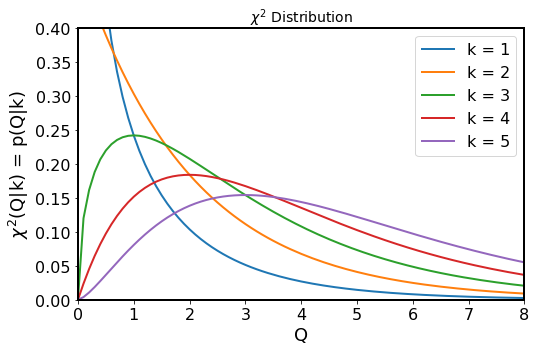

In [2]:
# Plot the chi^2 distribution for a range of k
q = np.linspace(0, 100, 1000)
kvals = [1, 2, 3, 4, 5]  # degrees of freedom
plt.figure(figsize=(8, 5))

for k in kvals: 
    p = stats.chi2.pdf(q, df=k)
    lab = "k = {0}".format(k)
    plt.plot(q, p, label=lab)
    
plt.legend()
plt.xlabel("Q")
plt.ylabel(r"$\chi^2$(Q|k) = p(Q|k)")
plt.title(r"$\chi^2$ Distribution")
plt.ylim(0, .4)
plt.xlim(0, 8)

k = 5, mean = 1.00, std = 0.63, sqrt(2/k) = 0.63
k = 10, mean = 1.00, std = 0.45, sqrt(2/k) = 0.45
k = 20, mean = 1.00, std = 0.32, sqrt(2/k) = 0.32
k = 40, mean = 1.00, std = 0.22, sqrt(2/k) = 0.22
k = 80, mean = 1.00, std = 0.16, sqrt(2/k) = 0.16


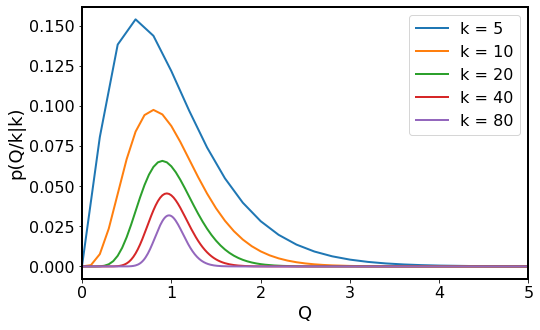

In [3]:
q = np.linspace(0, 1000, 1000)
kvals = [5, 10, 20, 40, 80]  # degrees of freedom
plt.figure(figsize=(8, 5))
for k in kvals: 
    p = stats.chi2.pdf(q, df=k)
    lab = "k = {0}".format(k)
    plt.plot(q/k, p, label=lab)
    mean = np.sum(p*q/k)
    std = np.sqrt( np.sum(p*np.power(q/k-mean, 2)) )
    print("k = {0}, mean = {1:.2f}, std = {2:.2f}, sqrt(2/k) = {3:.2f}".format(k, mean, std, np.sqrt(2/k)))

plt.xlabel("Q")
plt.ylabel("p(Q/k|k)")
plt.xlim(0, 5)
plt.legend()

#### Example 

Suppose we have 12 data points that we fit with a straight line, and we get $\chi^2=14.47$ for the best-fit slope and amplitude. In this case $k = N - n = 12 - 2 = 10$.

Then $\chi^2/{\rm d.o.f.} = 14.47/10 = 1.447 = 1+\sqrt{2/10}$, so this fit is only discrepant with the data at (exactly) the $1\sigma$ level. ($\sigma = \sqrt{2/k} = \sqrt{2/10} = 0.447$)

However, if we have 120 data points and the same $\chi^2/{\rm d.o.f.}$, then the discrepancy is $0.447/\sqrt{2/118} = 3.4\sigma$. 

If the value of $\chi^2/k$ is much _larger_ than $1 + \sqrt{2/k}$, then it probably indicates that either (1) the model is incorrect, or (2) the errors have been underestimated, or (3) the errors are significantly non-Gaussian, so that "outliers" are giving anomalously large contributions to $\chi^2$. Or maybe it indicates all three! 

It will generally take thought and further inspection to determine which of these is going on.

Note that these results apply unchanged for correlated (multi-variate Gaussian) errors, but the calculation of $\chi^2$ must correctly incorporate the error covariance matrix.

Thus, a specific instance of "(2) the errors have been underestimated" is "the covariance matrix has significant off-diagonal terms that have not been accounted for when computing $\chi^2$."

If the value of $\chi^2/k$ is much _smaller_ than $1-\sqrt{2/k}$ then it usually indicates that the errors have been underestimated.

### Linear constraints

The above results are consistent with our basic intuition.

If a model is correct and the errors are correct, then data will typically scatter about the model at about the level  of the $1\sigma$ error bars.

For $N$ data points we therefore expect $\chi^2/N \approx 1$, not $\chi^2 = 0$.

Each free parameter increases our ability to "fit the noise," so we expect a lower value of $\chi^2$.  We could in principle use a free parameter to exactly fit one data point, reducing the expected $\chi^2$ by one.

This turns out to be exactly right, as $\expect{\chi^2} = N-n$.

We may also have a linear constraint on the parameters, for example that they sum to one, or that the average
of the distribution is zero, or even just knowing the value of one parameter.

Gould (2003) gives formulae for the best-fit parameter values in this case.

He further shows that (_if_ both the constraints and the model are correct) then imposing $m$ constraints changes the expected value of $\chi^2$ to $\expect{\chi^2} + N - n + m$.

This again accords with intuition: imposing a constraint is equivalent to removing one degree of freedom.


### The $\chi^2$ hypothesis test

The frequentist version of the $\chi^2$ test is simply this: a model should be rejected if its value of $\chi^2$ (for the best-fit parameters) is large enough to be highly improbable.

Specifically, if the probability $P(>\chi^2)$ of obtaining a $\chi^2$ greater than the best-fit value is $q$, then the
model is rejected at the $1-q$ confidence level. For example, if $P(>\chi^2) = 0.01$, then the model is rejected at 99\% confidence.

The cumulative probability distribution $P(>\chi^2)$ can be found in tables or computed via python routines; it can be
approximated by a complementary error function (integral of a Gaussian) if the number of degrees of freedom is large.

One can make various complaints about this test --- Why integrate over values of $\chi^2$ larger than the observed one?  Why reject a model for anomalously large $\chi^2$ values but not for anomalously small ones? --- but it basically makes sense.  If a model has a very small $P(>\chi^2)$ it is probably wrong, or else the errors are wrong.


### An important note about $\chi^2$ parameter constraints

The likelihood of a set of parameter values relative to the best-fit values is $\exp(-\Delta\chi^2/2)$, where $\Delta\chi^2$ is the change in $\chi^2$ relative to its minimum value.

The 68% confidence interval on a parameter (in a one-parameter fit) corresponds to $\Delta\chi^2 = 1$, _not_ to $\Delta\chi^2/{\rm d.o.f.}=1$.

More than one astronomy paper has incorrectly used the latter.

### Bayesian Hypothesis Comparison

(See Ivezic $\S 5.4.$)

Bayes' Theorem gives a straightforward expression for the relative probability of two hypotheses:
$$
O_{12} = 
{p(H_1|DI) \over p(H_2|DI)} = 
  {p(H_1|I) \over p(H_2|I)} \times 
  {p(D|H_1 I) \over p(D| H_2I)}.
$$
We multiply our prior probabilities by the relative probabilities of obtaining the data under the two hypotheses.  The global likelihood $p(D|I)$ cancels out of the comparison.

This ratio $O_{12}$ is called the _odds ratio_.

Recall that $p(H|D I)$ is the posterior probability, $p(D|H I)$ is the likelihood, and $p(H|I)$ is the prior. In this case, $p(D|H I)$ is the marginal likelihood of hypothesis $H$. 

The ratio of the global likelihoods $B_{12} = p(D|H_1 I)/p(D|H_2 I)$ is called the Bayes factor.

If the hypotheses are simple, with no free parameters, then this comparison is straightforward.  However, if the hypotheses are models with parameters, we must integrate over the possible parameter values.  This can be complicated, but it also has interesting effects when comparing two models with different numbers of parameters, or even with the same number of parameters but different degrees of prior predictiveness.

(0, 1.2)

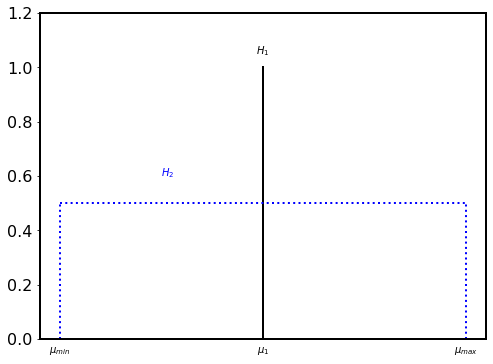

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
mumin = 3
mumax = 5
muone = 4
ax.plot([muone, muone], [0, 1], 'k-')
ax.plot([mumin, mumin], [0, 0.5], 'b:')
ax.plot([mumin, mumax], [0.5, 0.5], 'b:')
ax.plot([mumax, mumax], [0, 0.5], 'b:')
ax.text(muone, 1.05, s="$H_1$", ha="center")
ax.text(mumin+0.5, 0.6, s="$H_2$", color='blue')
ax.text(muone, -0.05, s="$\mu_{1}$", ha="center")
ax.text(mumin, -0.05, s="$\mu_{min}$", ha="center")
ax.text(mumax, -0.05, s="$\mu_{max}$", ha="center")

ax.set_xticks([])
ax.set_ylim(0, 1.2)

#### Example (From Loredo, $\S 5.3$)

We previously gave 
$$
p(D|\mu I) = 
(2\pi \sigma^2)^{-N/2} \exp\left[-{Ns^2 \over 2\sigma^2}\right] 
         \exp\left[-{N\over 2\sigma^2}(\xbar-\mu)^2\right]
$$
as the probability of obtaining the data $D=\{x_i\}$ drawn from a Gaussian distribution with mean $\mu$ and dispersion $\sigma$.

Consider the competing hypotheses

$H_1$ = mean of distribution is a specified value $\mu_1$

$H_2$ = mean of distribution is in range $\mu_{min} \leq \mu \leq \mu_{max}$, with a flat prior $p(\mu|I)=(\mu_{max}-\mu_{min})^{-1}$ in this range.

$H_2$ will _always_ fit the data better, unless the mean happens to be exactly $\mu_1$, in which case it fits equally well.

But does this mean $H_2$ is actually the preferred hypothesis?

$$
P(D|H_1 I) = K \times 
         \exp\left[-{N\over 2\sigma^2}(\xbar-\mu_1)^2\right],
$$
where
$$
K = (2\pi \sigma^2)^{-N/2} \exp\left[-{Ns^2 \over 2\sigma^2}\right] 
$$
is independent of $\mu_1$.

$$\eqalign{
p(D|H_2 I) &= \int_{\mu_{min}}^{\mu_{max}} p(D|\mu I) p(\mu |I) d\mu  \cr
           &= K (\mu_{max}-\mu_{min})^{-1} 
   \int_{\mu_{\rm min}}^{\mu_{\rm max}}
       d\mu\exp\left[-{N\over 2\sigma^2}(\xbar-\mu)^2\right].
}
$$
If $\mu_{max}-\xbar$ and $\xbar-\mu_{min}$ are both $\gg \sigma/\sqrt{N}$, then the integral is just $(2\pi\sigma^2/N)^{1/2}$, since a Gaussian $(2\pi\sigma^2)^{-1/2} \exp(-x^2/2\sigma^2)$ integrates to one.

In this case
$$
{p(D|H_1 I) \over p(D|H_2 I)} = 
  {(\mu_{max}-\mu_{min}) \over
  \left(2\pi\sigma^2 / N\right)^{1/2}}
  \exp\left[-{N\over 2\sigma^2}(\xbar-\mu_1)^2\right].
$$

If we considered the two hypotheses equally probable before hand, $p(H_1|I) = p(H_2 | I)$, then this ratio is also the ratio of posterior probabilities.

Model 2 is "penalized" for having less predictive power than Model 1, and the amount of the penalty depends on the ratio of $(\mu_{max}-\mu_{min})$ to the actual uncertainty in the mean $\sigma/\sqrt{N}$.

Model 1 is penalized because it doesn't fit the data as well as the best fit versions of Model 2.  If it is nonetheless fairly close, then it may win out as the more probable hypothesis, otherwise it won't.

Text(0, 0.5, '$p(D|H_1 I)/p(D|H_2 I)$')

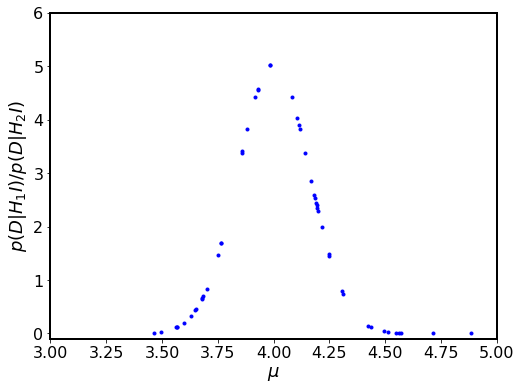

In [5]:
# meanvals = np.linspace(3.5, 4.5, 10)
N = 10
sigma = 0.5
mumin = 3
muone = 4
mumax = 5

def probratio(xmean, sigma, N):
    # ratio of the probabilities for the two hypothesis
    return ( (mumax - mumin)/np.sqrt(2*np.pi*sigma*sigma/N) ) * np.exp( -0.5*N*np.power( (xmean-muone)/sigma, 2 ) )

meanvals = np.linspace(3.5, 4.5, 50)

plt.figure(figsize=(8, 6))
for meanval in meanvals: 
    x = np.random.normal(meanval, sigma, size=N)
    xmean = np.mean(x)
    y = probratio(xmean, sigma, N)
    plt.plot(xmean, y, 'b.')

plt.ylim(-0.1, 6)
plt.xlim(3, 5)
plt.xlabel(r"$\mu$")
plt.ylabel(r"$p(D|H_1 I)/p(D|H_2 I)$")

For another example, see Ivezic $\S 5.4.2$.  


More generally, we can see from the structure of the integral $\int p(\theta|I)p(D|\theta I)d\theta$ that a model with a free parameter $\theta$ will gain to the extent that its best fit value $\hat\theta$ 
yields a greater likelihood $p(D|\hat{\theta} I)$, but will lose to the extent
that $p(\theta | I)$ is broad and "spreads out" the predictive power.

The Bayesian expression for hypothesis comparison thus yields Occam's razor as a _result_: the preferred model is the one that fits the data adequately with the least freedom to be adjusted to do so.

In principle, this provides a well defined way to decide whether a more complicated model is "worth it."

In general cases, the integrals over parameter values may be impossible to do analytically, though they can probably be done numerically.

Note that while we have used a Gaussian example here, the analysis is not restricted to any particular probability distribution.

Indeed, one could use these ratio tests to compare the hypothesis that the data have Gaussian errors with a fixed dispersion to the hypothesis that there is an additional "outlier" population drawn from a broader Gaussian, or that the error distribution is exponential instead of Gaussian.

### Rules of thumb

Leaving aside the Bayesian approach, there is another important $\Delta\chi^2$ rule of thumb: an additional parameter should reduce $\chi^2$ by $\Delta\chi^2 > 1$ to be considered significant.  

Roughly, you can think of this rule as saying that one parameter can be chosen to perfectly explain one data point, so it should typically reduce $\Delta\chi^2$ by one even if the more complicated model has no more explanatory power than the simpler model.

This rule can be justified more rigorously in terms of the expected value of $\chi^2$ in linear model fits, where adding $n$ parameters reduces the expected value of $\chi^2$ by $n$.

A $\Delta\chi^2 =1$ is enough to prefer one parameter value over another at $1\sigma$, but it would be an undemanding criterion for accepting a model that was actually more complicated.

The Aikake information criterion (AIC, Ivezic $\S 4.3.2$) is a popular choice for frequentist comparison of models with different numbers of parameters. This is ${\mathrm AIC} \equiv -2\ln \left[L^0(M)\right] + 2 k$, or for small samples (Burnham & Anderson suggest $N/k < 40$): 
$$
{\rm AIC} \equiv -2\ln \left[L^0(M)\right] + 2 k + \frac{2k (k+1)}{N-k-1}
$$

In terms of the Bayesian odds ratio, a ratio $>10$ might be taken as interesting evidence for one hypothesis over another.

For equal priors (so that the odds ratio equals the likelihood ratio) and Gaussian errors, an odds ratio of 10 corresponds to $\Delta\chi^2 = -2\ln 0.1 = 4.6$ or a $2.1\sigma$ difference.

An odds ratio of 100 corresponds to $\Delta\chi^2=13.8$ or a $3.7\sigma$ difference, which might be taken as "decisive" evidence.

The Bayesian Information Criterion (BIC, Ivezic $\S 5.4.3$) is an approximate method of estimating the odds ratio from the maximum values of the data likelihood, without marginalizing over the full parameter space.

The preferred model is the one with the smaller value of 
$$
{\rm BIC} \equiv -2\ln \left[L^0(M)\right] + k\ln N
$$
where $L^0(M)$ is the likelihood of the model with best-fit  parameter values, $k$ is the number of model parameters,  and $N$ is the number of data points. Note that the BIC penalizes models with lots of parameters. If two models are equally successful, the model with fewer parameters wins. 

### Absolute model assessment

In a Bayesian approach, there is really no such thing as an absolute model assessment.  

If one has an exhaustive set of possible hypotheses, $H_1$, $H_2$, ... $H_N$, then one can ask about the probability that any one of those hypotheses is correct
$$ 
p(H_i|DI) = p(H_i|I) {p(D|H_i I) \over p(D|I)},
$$
where 
$$
p(D|I) = \sum_{i=1}^N p(D|H_i I)
$$
is computed by summing over all of the hypotheses.

But there isn't a Bayesian way to assess a hypothesis in isolation without specifying alternatives.


The traditional way to do an absolute model assessment in the frequentist approach is to compute some statistic, say $\chi^2$, that increases for worse fits, then ask how often one would expect to get a value that large _or larger_ if the hypothesis were true.

If this probability $\alpha$ is small, then the model is rejected at the $1-\alpha$ confidence level.

There are some problems with this approach: the answer depends on what statistic you choose, it may depend on what you think the alternative "data sets" are, and there is sometimes ambiguity about what "tail" of the distribution one should consider.  For example, low $\chi^2$ values can be as improbable as high $\chi^2$ values --- should a model be rejected because it fits the data too well?

Despite these problems, these frequentist assessments seem to make good sense in some cases, and choices among seemingly ambiguous alternatives (e.g., whether to reject low $\chi^2$ values) can often be made sensibly in the context of a specific problem.


### Example calculation

In [6]:
def calc_lnlike(theta, x_i, yhat_i, sig_y_i):
    '''
    Return the natural log of the likelihood fit of an arbitrary order polynomial
    
    Parameters
    ----------
    
    observations: x_i, yhat_i
    uncertainties: sig_y_i
    model parameters: theta
       where theta are the coefficients of a polynomial such that theta[0] + theta[1]*x + theta[2]*x*x + ... 
    '''
    f = Polynomial(theta) 

    like = np.power( yhat_i - f(x_i), 2)/(2*sig_y_i*sig_y_i)
    
    return -0.5*np.sum(like)

In [23]:
# Create data with heteroscedastic errors

def adderrors(y_i, sig_y_i):
    yhat_i = y_i.copy()
    # Apply the scatter to x and y
    for i in range(Npts):
        yhat_i[i] += np.random.normal(0, sig_y_i[i])

    return yhat_i


np.random.seed(1216)
Npts = 200
x_i = np.linspace(0, 10, Npts)

# Define truth
theta_true = np.array([5, 0, .5, .2])
f_true = Polynomial(theta_true)
y_i = f_true(x_i)
sig_y = .5

# Calculate heteroscedastic errors
sig_y_i = np.random.uniform(0.5*sig_y, sig_y, Npts) 

# Calculate homoscedastic errors
# sig_y_i = 0.5*np.ones(Npts) # np.random.uniform(0.25, 0.5, Npts) 

# These are the data to fit
yhat_i = adderrors(y_i, sig_y_i)

In [24]:
def calc_aic(l, n, k):
    '''
    Return AIC based on sample size and number of parameters
    '''
    if n/k < 40: 
        return -2.*l + 2.*k + 2*k*(k+1)/(n-k-1)
    else: 
        return -2.*l + 2.*k

# Orders of polynomial from 0th to 6th order 
numparams = np.linspace(1, 6, 6, dtype=int)

# Multiply output by -1 to use with minimize()
func = lambda *args: -calc_lnlike(*args)

results = {}

# Fit polynomials of progressively higher order
for num in numparams:
    theta_guess = np.array([1, 2, 1, 0, 0])
    theta = theta_guess[:num]
    x0 = theta + np.random.randn(len(theta))
    print("Starting guess ", x0)
    results[num] = minimize(func, x0, args=(x_i, yhat_i, sig_y_i), method="BFGS")
    errs = np.sqrt(np.diag(results[num].hess_inv)) # The inverse of the Hessian matrix is the covariance matrix
    print("Coefficients: ", results[num].x)
    print("Uncertainties on coefficients: ", errs)
    print("Input values: ", theta_true)
    llike = calc_lnlike(results[num].x, x_i, yhat_i, sig_y_i)
    results[num]['aic'] = calc_aic(llike, len(yhat_i), len(theta) ) # -2*llike + 2*num
    results[num]['bic'] = -2*llike + num*np.log(Npts)
    results[num]['chi2'] = -2*llike
    print("Maximum Likelihood: ", llike, "AIC = ",  results[num]['aic'], "BIC = ", results[num]['bic'])

Starting guess  [0.48375133]
Coefficients:  [74.32480034]
Uncertainties on coefficients:  [0.03491561]
Input values:  [5.  0.  0.5 0.2]
Maximum Likelihood:  -2137037.561845353 AIC =  4274077.123690706 BIC =  4274080.422008072
Starting guess  [-1.03896115  3.54688698]
Coefficients:  [-46.79800943  23.57478936]
Uncertainties on coefficients:  [0.0719098  0.01223562]
Input values:  [5.  0.  0.5 0.2]
Maximum Likelihood:  -280883.720373885 AIC =  561771.44074777 BIC =  561778.0373825032
Starting guess  [ 2.72290447  1.81334492 -0.09849624]
Coefficients:  [ 16.0529308  -12.44027849   3.53755335]
Uncertainties on coefficients:  [0.10638003 0.04705754 0.00448727]
Input values:  [5.  0.  0.5 0.2]
Maximum Likelihood:  -5581.067381270321 AIC =  11168.134762540642 BIC =  11178.029714640286
Starting guess  [ 3.03437496  3.1706963  -0.09274998  0.65200129]
Coefficients:  [ 5.06838171 -0.05122889  0.51001308  0.19935083]
Uncertainties on coefficients:  [0.15296603 0.12853037 0.02929479 0.00190225]
In

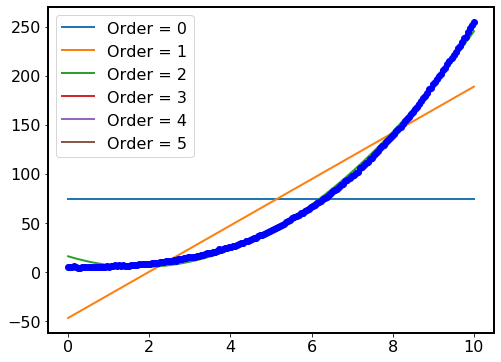

In [25]:
# Plot the data and fits

plt.figure(figsize=(8,6))
plt.errorbar(x_i, yhat_i, xerr=None, yerr=sig_y_i, fmt='bo')
x_plot = np.linspace(0, 10, 100)
for num in numparams:
    fplot = Polynomial(results[num].x)
    y_plot = fplot(x_plot)
    plt.plot(x_plot, y_plot, label="Order = {}".format(num-1))
    
plt.legend()

0 AIC = 4274077.123690706 BIC = 4274080.422008072 Chi2 = 4274075.123690706
1 AIC = 561771.44074777 BIC = 561778.0373825032 Chi2 = 561767.44074777
2 AIC = 11168.134762540642 BIC = 11178.029714640286 Chi2 = 11162.134762540642
3 AIC = 108.90046864039593 BIC = 122.09373810658808 Chi2 = 100.90046864039593
4 AIC = 110.2207303076041 BIC = 126.71231714034428 Chi2 = 100.2207303076041
5 AIC = 110.22099488778079 BIC = 132.010899087069 Chi2 = 100.22099488778079


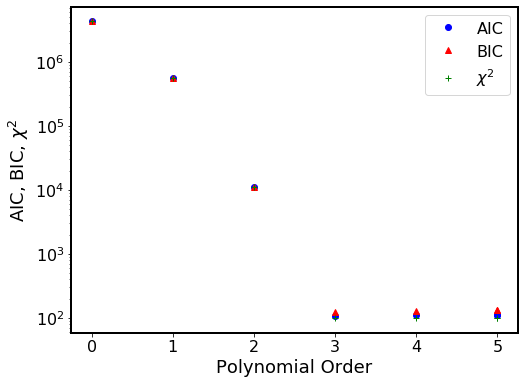

In [26]:
# Plot AIC, BIC, and Chi2

plt.figure(figsize=(8,6))

for num in numparams:
    fplot = Polynomial(results[num].x)
    y_plot = fplot(x_plot)
    plt.plot(num-1, results[num]['aic'], 'bo')
    plt.plot(num-1, results[num]['bic'], 'r^')
    plt.plot(num-1, results[num]['chi2'], 'g+')
    print("{0} AIC = {1} BIC = {2} Chi2 = {3}".format(num-1, results[num]['aic'], results[num]['bic'], results[num]['chi2']))

plt.plot(num-1, results[num]['aic'], 'bo', label='AIC')
plt.plot(num-1, results[num]['bic'], 'r^', label='BIC')
plt.plot(num-1, results[num]['chi2'], 'g+', label=r'$\chi^2$')
    
plt.yscale('log')
plt.xlabel("Polynomial Order")
plt.ylabel(r"AIC, BIC, $\chi^2$")
plt.xticks(ticks=numparams-1, labels=numparams-1)
plt.legend()